# Workflow:
## Newly measured data will have to be converted to h5 files using convert_to_h5( directory )
## Then you load all the files in that directory using load_files( directory ) 

In [5]:
# Import packages

# Ensure that this code works on both python 2 and python 3
from __future__ import division, print_function, absolute_import, unicode_literals

# basic numeric computation:
import numpy as np

# The package used for creating and manipulating HDF5 files:
import h5py

# Plotting and visualization:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mpltick

# for downloading files:
import wget
import os

# multivariate analysis:
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
import subprocess
import sys

def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])
# Package for downloading online files:
# finally import pycroscopy:
try:
    import pyUSID as usid
except ImportError:
    print('pyUSID not found.  Will install with pip.')
    import pip
    install('pyUSID')
    import pyUSID as usid
try:
    import pycroscopy as px
except ImportError:
    print('pycroscopy not found.  Will install with pip.')
    import pip
    install('pycroscopy')
    import pycroscopy as px
from pycroscopy.viz import cluster_utils


#from pptx import Presentation
#from pptx.util import Inches


def get_channels( file, fmt='raw' ):

    topo1 = usid.USIDataset(file['Measurement_000/Channel_000/Raw_Data']) 
    ampl1 = usid.USIDataset(file['Measurement_000/Channel_001/Raw_Data']) 
    phase1 = usid.USIDataset(file['Measurement_000/Channel_003/Raw_Data']) 
    ampl2 = usid.USIDataset(file['Measurement_000/Channel_002/Raw_Data']) 
    phase2 = usid.USIDataset(file['Measurement_000/Channel_004/Raw_Data']) 
    
    
    if fmt == 'arr':
        topo1_nd = np.transpose(topo1.get_n_dim_form().squeeze())
        ampl1_nd = np.transpose(ampl1.get_n_dim_form().squeeze())
        ampl2_nd = np.transpose(ampl2.get_n_dim_form().squeeze())
        phase1_nd = np.transpose(phase1.get_n_dim_form().squeeze())
        phase2_nd = np.transpose(phase2.get_n_dim_form().squeeze())
    
        if len(file['Measurement_000']) >10:
            topo2 = usid.USIDataset(file['Measurement_000/Channel_006/Raw_Data']) 
            topo2_nd = np.transpose(topo2.get_n_dim_form().squeeze())
        
            return [topo1_nd, ampl1_nd, phase1_nd, ampl2_nd, phase2_nd, topo2_nd]
        return [topo1_nd, ampl1_nd, phase1_nd, ampl2_nd, phase2_nd]
        
    
    if len(file['Measurement_000']) >10:
        topo2 = usid.USIDataset(file['Measurement_000/Channel_006/Raw_Data']) 
        topo2_nd = np.transpose(topo2.get_n_dim_form().squeeze())
        
        return [topo1, ampl1, phase1, ampl2, phase2, topo2]
    
    return [topo1, ampl1, phase1, ampl2, phase2]
    
def single_image_plot(image, title, xvec, cmap=plt.cm.afmhot, zrange=None, axis=None, fig=None, posn=None, **kwargs):
    if axis is None:
        fig, axis = plt.subplots()   
        #gs = gridspec.GridSpec(1)

    #xvec = np.linspace( 0, usid.hdf_utils.get_attributes(experiment[i]['Measurement_000'])['ScanSize']/10**(-6), len(image[0]))
    
    if zrange is None:
        
        usid.plot_utils.plot_map(axis, image, cmap=cmap, x_vec = xvec, y_vec=xvec)
        #axis.set_title(title)    
        axis.set_xlabel('X ($\mathrm{\mu}$m)')
        axis.set_ylabel('Y ($\mathrm{\mu}$m)')
    else:
        
        usid.plot_utils.plot_map(axis, image, cmap=cmap, vmin=zrange[0], vmax=zrange[1], x_vec = xvec, y_vec=xvec, **kwargs)
        #axis.set_title(title)        
        axis.set_xlabel('X ($\mathrm{\mu}$m)')
        axis.set_ylabel('Y ($\mathrm{\mu}$m)')

    return fig, axis
    
    
def multi_image_plot(images, experiment, titles=None, cmap=plt.cm.afmhot, 
                     zrange=None, axis=None, fig=None,  gs=None, 
                     posn=None, ntick=4, **kwargs):
    """
    Handy function that plots three image channels side by side with colorbars

    Parameters
    ----------
    images     : list or array-like
                List of three images defined as 2D numpy arrays
    experiment : list or array
                The list of datafiles from the PFM measurements
    titles     : (Optional) list or array-like (optional)
                List of the titles for each image
    cmap       : (Optional) matplotlib.pyplot colormap object or string 
                Colormap to use for displaying the images
    zrange     : (Optional) list of array-like 
                List of z_ranges for height, amplitude, and phase images respectively 
    axis       : (Optional) matplotlib axis 
    
    fig        : (Optional) matplotlib figure 

    Returns
    -------
    fig : Figure
        Figure containing the plots
    axes : 1D array_like of axes objects
        Axes of the individual plots within `fig`
    """
    ph1 = -90
    ph2 = ph1 + 360
    z_range = [ (-2, 2), (0, 0.7),(ph1,ph2) ] # Preset height, amplitude, and phase channel max/min

    channel1 = [ t1, a1, p1 ]
    #channel2 = [ t1, a2, p2 ]
    titles = ['topo', 'ampl', 'phase']
    if axis is None:

        fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(12,4))   
        gs = gridspec.GridSpec(1, 3)

    xvec = np.linspace( 0, usid.hdf_utils.get_attributes(experiment[i]['Measurement_000'])['ScanSize']/10**(-6), len(images[0]))
    axes = []
    if zrange is None:
        
        for pos, img, title in zip(gs, images, titles):
            axis = fig.add_subplot(pos)
            usid.plot_utils.plot_map(axis, img, stdevs=3, num_ticks=4,
                                     cmap=cmap, x_vec = xvec, y_vec=xvec)
            axis.set_title(title, fontsize=12) 
            axis.set_xlabel('X ($\mathrm{\mu}$m)')
            if pos == gs[0]:
                axis.set_ylabel('Y ($\mathrm{\mu}$m)')
            axes.append(axis)
    else:
        for pos, img, title, zrange in zip(gs, images, titles, zrange):
            axis = fig.add_subplot(pos)
            usid.plot_utils.plot_map(axis, img, cmap=cmap, num_ticks=ntick,
                                     vmin=zrange[0], vmax=zrange[1],
                                     x_vec = xvec, y_vec=xvec)
            axis.set_title(title)        
            axis.set_xlabel('X ($\mathrm{\mu}$m)')
            if pos == gs[0]:
                axis.set_ylabel('Y ($\mathrm{\mu}$m)')
            axes.append(axis)


    return fig, axes

def convert_to_h5( directory ):
    trans = px.io.translators.igor_ibw.IgorIBWTranslator()
    c = 1
    for file in os.listdir( diry ):
        if file.endswith(".ibw"):
            tmp = trans.translate( diry + file)
            h5_file = h5py.File( tmp, mode='r' ) 
            print(os.path.join( diry, file ) + " - " + str(c))
            experiment.append( h5_file )
            h5_file.close()
            c = c + 1
    print('Completed')
    return
    
def load_files( directory ):
    
    experiment = [ h5py.File( os.path.join(directory,file), mode='r' ) for file in os.listdir(diry) if file.endswith(".h5")]
    filenames = [ file for file in os.listdir(diry) if file.endswith(".h5")]
    
    return experiment, filenames

##### Here

In [6]:
import os

scans = []
topo, ampl1, ampl2, phase1, phase2 = [], [], [], [], []
experiment = []

# Here you can paste the directory of the scans you want to look at
diry = r"C:\Users\oliver\OneDrive - UNSW\Experiments 2019\PFM\191128"
c = 0



# Only execute the below cell if you want to convert IBW files to h5. This conversion only needs to be done once.

In [48]:

convert_to_h5( diry )

C:\Users\oliver\anaconda3\lib\site-packages\pyUSID\io\hdf_utils\simple.py:1081: UserWarning: In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying
  warn('In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying')
C:\Users\oliver\anaconda3\lib\site-packages\pyUSID\io\usi_data.py:151: UserWarning: This dataset does not have an N-dimensional form
  warn('This dataset does not have an N-dimensional form')


(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
C:\Users\oliver\OneDrive - UNSW\Experiments 2020\Asylum\200912\\OP18N0010000.ibw - 1
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
C:\Users\oliver\OneDrive - UNSW\Experiments 2020\Asylum\200912\\OP18N0010001.ibw - 2
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
(65536, 1)
C:\Users\oliver\OneDrive - UNSW\Experi

In [27]:
%qtconsole

# Load files in directory here

In [7]:
expt, fnames = load_files( diry )
j=0
for name in fnames:
    print(name + ' - ' + str(j))
    j += 1

P0115OP0000.h5 - 0
P0115OP0001.h5 - 1
P0115OP0002.h5 - 2
P0115OP0003.h5 - 3
P0115OP0004.h5 - 4
P0115OP0005.h5 - 5
P0115OP0006.h5 - 6
P0115OP0007.h5 - 7
P0115OP0008.h5 - 8
P0115OP0009.h5 - 9
P0119CK0000.h5 - 10
P0119CK0001.h5 - 11
P0119CK0002.h5 - 12
P0119CK0003.h5 - 13
P0119CK0004.h5 - 14
P0119CK0005.h5 - 15
P0119CK0006.h5 - 16
P0119CK0007.h5 - 17
P0119CK0008.h5 - 18
P0119CK0009.h5 - 19
P0119CK0010.h5 - 20
P0119CK0011.h5 - 21
P0119CK0012.h5 - 22
P0119CK0013.h5 - 23
P0119CK0014.h5 - 24


# Use the numbers in previous cell output to pick which scan you want to look at
## The cell below loads the data from one scan into variables representing the topography, amplitude1, phase1, amplitude2, and phase2 channels

In [16]:

i = 8
plt.close(fig='all')
[t1, a1, p1, a2, p2] = get_channels( expt[i], fmt='arr' )

C:\Users\oliver\anaconda3\lib\site-packages\pyUSID\io\usi_data.py:151: UserWarning: This dataset does not have an N-dimensional form
  warn('This dataset does not have an N-dimensional form')
C:\Users\oliver\anaconda3\lib\site-packages\pyUSID\io\usi_data.py:151: UserWarning: This dataset does not have an N-dimensional form
  warn('This dataset does not have an N-dimensional form')
C:\Users\oliver\anaconda3\lib\site-packages\pyUSID\io\usi_data.py:151: UserWarning: This dataset does not have an N-dimensional form
  warn('This dataset does not have an N-dimensional form')
C:\Users\oliver\anaconda3\lib\site-packages\pyUSID\io\usi_data.py:151: UserWarning: This dataset does not have an N-dimensional form
  warn('This dataset does not have an N-dimensional form')
C:\Users\oliver\anaconda3\lib\site-packages\pyUSID\io\usi_data.py:151: UserWarning: This dataset does not have an N-dimensional form
  warn('This dataset does not have an N-dimensional form')


# Plotting
### The below cell plots the topography, amplitude and phase of the scan. 
#### You can pick which amplitude or phase channel you use by changing a1 to a2 and vice versa when defining the "channel1" variable
#### You can adjust the topography, amplitude and phase ranges by changing the numbers in the z_range, a_range, and p_range variables

Text(0.8, 0.9, 'P0115OP0008')

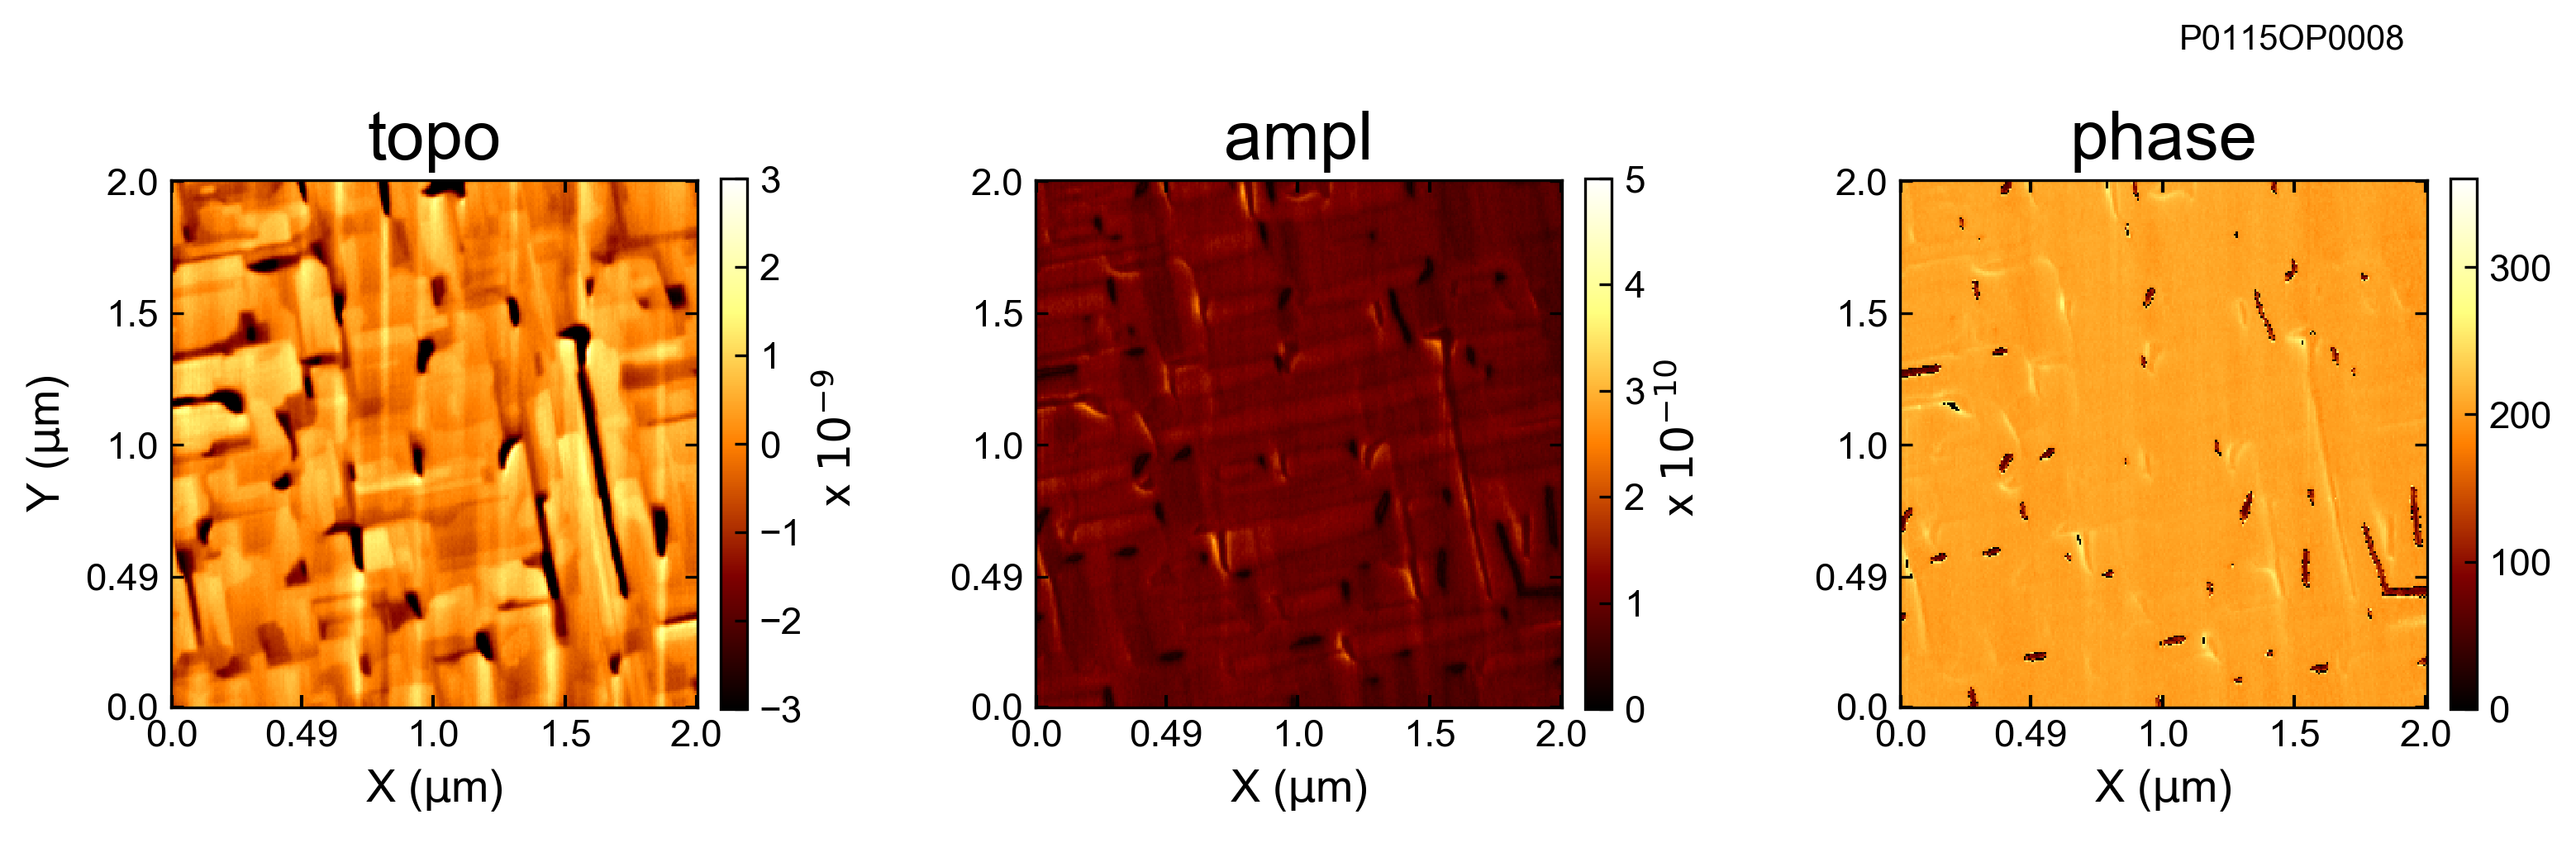

In [17]:

%matplotlib inline
plt.style.use('PFM')

channel1 = [t1.T, a1.T, p1.T]
z_range = (-3,3)
a_range = (0, 5)
p_range = (0, 360)
ranges = [z_range, a_range, p_range]
fig, ax = plt.subplots( figsize=(12,4) )

gs = gridspec.GridSpec(1,3)
ax.axis('off')

fig, ax = multi_image_plot( channel1, expt, fig=fig, axis=ax, gs=gs, zrange=ranges, ntick=5 )

'''
Uncomment the below line to save the figure to a .SVG file. You can also change the filetype it saves 
by just changing the '.svg' section to '.png' or whatever your preference is. 
'''
#plt.savefig(diry + fnames[i][:-3] + '.svg', transparent=True)

fig.text(0.8, 0.9, fnames[i][:-3])


# Roughness calculations

In [35]:
avgT = np.average(t1)
roughness = np.std(t1)
print(roughness)

1.3649563e-09


In [95]:
plt.savefig(usid.hdf_utils.get_attributes(experiment[i]['Measurement_000'])['FileName'][:-1-3], fmt='png')
img_path = usid.hdf_utils.get_attributes(experiment[i]['Measurement_000'])['FileName'][:-1-3] + '.png'

IndexError: list index out of range

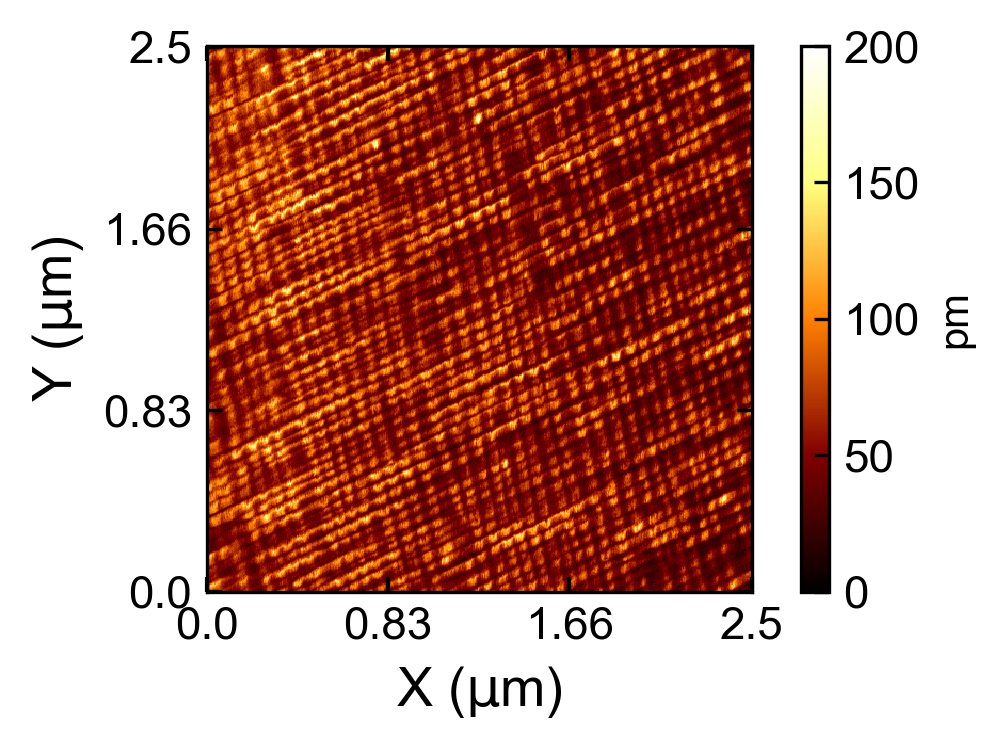

In [73]:
xvec = np.linspace( 0, 
                   usid.hdf_utils.get_attributes(expt[i]['Measurement_000'])['ScanSize']/10**(-6),
                   len(t1))
fig, ax = single_image_plot( a1/10**(-12), fnames[i], xvec, zrange=(0,200), cbar_label='pm')
fig.tight_layout()
plt.savefig(diry + fnames[i][:-3] + '_ampl.svg', transparent=True)

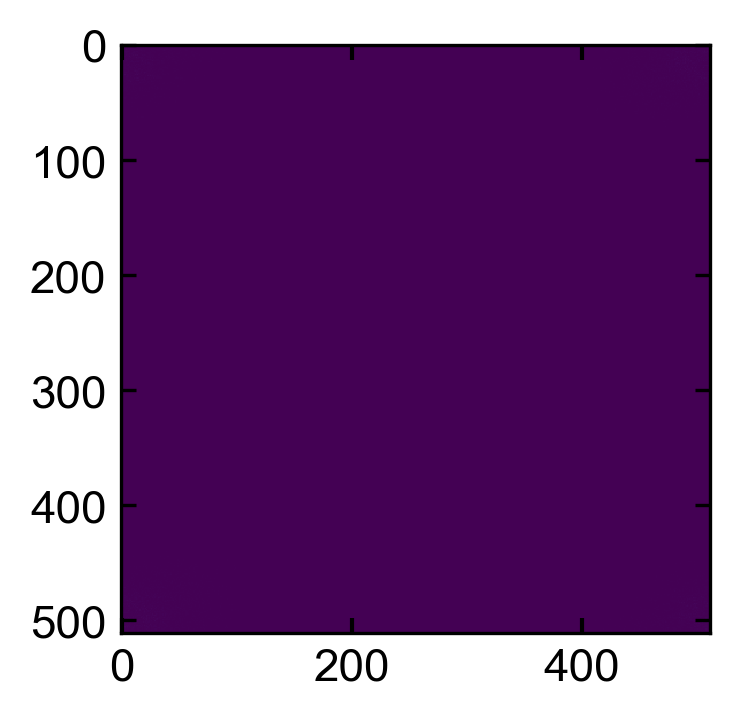

In [45]:
ff_a2 =  np.fft.fft2(a2)


plt.imshow(np.abs(ff_a2))

In [179]:
print('Datasets and datagroups within the file:\n------------------------------------')
usid.hdf_utils.print_tree(expt[10])

Datasets and datagroups within the file:
------------------------------------
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Raw_Data
  ├ Channel_001
    -----------
    ├ Raw_Data
  ├ Channel_002
    -----------
    ├ Raw_Data
  ├ Channel_003
    -----------
    ├ Raw_Data
  ├ Channel_004
    -----------
    ├ Raw_Data
  ├ Channel_005
    -----------
    ├ Raw_Data
  ├ Position_Indices
  ├ Position_Values
  ├ Spectroscopic_Indices
  ├ Spectroscopic_Values


In [320]:
left = Inches(1)
top = Inches(0)
#pic = slide.shapes.add_picture(img_path, left, top)

#left = Inches(5)
height = Inches(2.5)
pic = slide.shapes.add_picture(img_path, left, top, height=height)



In [324]:
prs.save('Crafting_copy_PFM.pptx')

NameError: name 'ampl1' is not defined

In [5]:


h5_topo = usid.USIDataset(h5_file['Measurement_000/Channel_006/Raw_Data'])
h5_ampl1 = usid.USIDataset(h5_file['Measurement_000/Channel_001/Raw_Data'])
h5_phase1 = usid.USIDataset(h5_file['Measurement_000/Channel_003/Raw_Data'])
h5_ampl2 = usid.USIDataset(h5_file['Measurement_000/Channel_002/Raw_Data'])
h5_phase2 = usid.USIDataset(h5_file['Measurement_000/Channel_005/Raw_Data'])

z_range = [ (0.0, 0.3), (0, 2), (0, 360) ]

fig, ax = multi_image_plot( [h5_topo.get_n_dim_form().squeeze(), h5_ampl1.get_n_dim_form().squeeze(), h5_phase1.get_n_dim_form().squeeze()], 
                           ['topo', 'ampl', 'phase'], zrange=z_range )

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Raw_Data
  ├ Channel_001
    -----------
    ├ Raw_Data
  ├ Channel_002
    -----------
    ├ Raw_Data
  ├ Channel_003
    -----------
    ├ Raw_Data
  ├ Channel_004
    -----------
    ├ Raw_Data
  ├ Channel_005
    -----------
    ├ Raw_Data
  ├ Channel_006
    -----------
    ├ Raw_Data
  ├ Position_Indices
  ├ Position_Values
  ├ Spectroscopic_Indices
  ├ Spectroscopic_Values


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x28d30fefa48>)

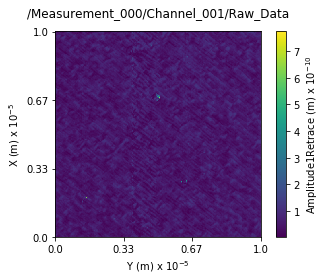